# Loan Default Prediction
## Team Members:
* Muhammad Faisal Shabbir        
* Stephanie Yin
* Matt Arbos

Github link: https://github.com/mfaisalshabbir87/loan_default_prediction

In [33]:
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing,metrics 
from IPython.core.display import HTML
pd.set_option("display.max_columns",75)
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import linear_model,svm
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

<p>
<span style="color:blue">
> Importing data of Lending club for the years 2012-14
</span>
</p>

In [34]:
df2012_13 = pd.read_csv('Loan_2012_2013.csv',low_memory=False,skiprows=1)
df2014 = pd.read_csv('Loan_2014.csv',low_memory=False,skiprows=1)

## Data Cleaning

<p>
<span style="color:blue">
> Merged datasets of 2012-14 <br>
> Removed all empty columns ( these are the columns with personal data of the borrowers. These are not disclosed by the company. so we dropped them)<br>
> Target variable(Borrower is a Loan defaulter) - encoded to 0 or 1<br>
</span>
</p>

In [35]:
dataset = pd.concat([df2012_13, df2014]) #merging 2012 to 2014 datasets
dataset = dataset.iloc[:,2:111]          #removing empty columns
empty_cols = [i for i in range(45,72)]   #more empty columns
dataset = dataset.drop(dataset.columns[empty_cols],axis=1)
data_with_loanstatus_sliced = dataset[(dataset['loan_status']=="Fully Paid") | (dataset['loan_status']=="Charged Off")]
di = {"Fully Paid":0, "Charged Off":1}   #converting target variable to boolean
Dataset_withBoolTarget= data_with_loanstatus_sliced.replace({"loan_status": di})

In [36]:
Dataset_withBoolTarget['loan_status'].value_counts()
print("Current shape of dataset :",Dataset_withBoolTarget.shape)
Dataset_withBoolTarget.head(3)

Current shape of dataset : (402905, 82)


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,...,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,7550.0,7550.0,7550.0,36 months,16.24%,266.34,C,C5,Special Order Fulfillment Clerk,3 years,RENT,28000.0,Not Verified,Dec-2013,0,n,NaN,NaN,debt_consolidation,Debt consolidation,951xx,CA,8.40,0.0,Oct-2010,0.0,NaN,NaN,4.0,0.0,5759.0,72%,5.0,w,0.0,0.0,9600.454631,...,1.0,1440.0,160.0,96.0,0.0,0.0,NaN,38.0,17.0,17.0,0.0,17.0,NaN,17.0,NaN,0.0,2.0,4.0,2.0,2.0,0.0,4.0,5.0,4.0,4.0,0.0,0.0,0.0,0.0,100.0,100.0,0.0,0.0,8000.0,5759.0,4000.0,0.0
1,27600.0,27600.0,27600.0,60 months,19.97%,730.78,D,D5,Street Operations Supervisor,6 years,MORTGAGE,73000.0,Source Verified,Dec-2013,1,n,NaN,Borrower added on 12/31/13 > I had some wate...,debt_consolidation,Consolidation of debt and home improve.,802xx,CO,23.13,1.0,Jun-1989,1.0,7.0,NaN,10.0,0.0,27003.0,82.8%,24.0,f,0.0,0.0,30303.089986,...,2.0,24161.0,4853.0,74.7,1.0,0.0,173.0,294.0,4.0,4.0,4.0,4.0,7.0,6.0,7.0,3.0,5.0,7.0,5.0,11.0,4.0,7.0,16.0,7.0,10.0,0.0,0.0,1.0,1.0,87.5,80.0,0.0,0.0,261675.0,37808.0,19200.0,14075.0
2,8000.0,8000.0,8000.0,36 months,10.99%,261.88,B,B2,PARTS MANAGER,2 years,MORTGAGE,33000.0,Not Verified,Dec-2013,1,n,NaN,NaN,debt_consolidation,My Life Saving Loan :),800xx,CO,15.75,0.0,Jul-1991,1.0,NaN,104.0,9.0,1.0,7203.0,34.6%,16.0,f,0.0,0.0,5622.500000,...,2.0,1772.0,2255.0,72.5,0.0,0.0,129.0,269.0,14.0,14.0,0.0,18.0,NaN,6.0,NaN,0.0,3.0,5.0,4.0,7.0,2.0,8.0,14.0,5.0,9.0,0.0,0.0,0.0,0.0,100.0,75.0,1.0,0.0,33226.0,15949.0,8200.0,12426.0


In [40]:
dataset=Dataset_withBoolTarget.dropna(thresh = 340000,axis=1) #340000 is minimum number of non-NA values
print("Current shape of dataset :",dataset.shape)

Current shape of dataset : (402905, 76)


<p>
<span style="color:blue">
> some more columns were dropped in the below cell. some of them are not related to our target variable and some of them are redundant. <br>
</span>
</p>

In [38]:
del_col_names = ["delinq_2yrs",  "last_pymnt_d", "chargeoff_within_12_mths","delinq_amnt","emp_title", "term", "emp_title", "pymnt_plan","purpose","title", "zip_code", "verification_status", "dti","earliest_cr_line", "initial_list_status", "out_prncp",
"pymnt_plan", "num_tl_90g_dpd_24m", "num_tl_30dpd", "num_tl_120dpd_2m", "num_accts_ever_120_pd", "delinq_amnt", 
"chargeoff_within_12_mths", "total_rec_late_fee", "out_prncp_inv", "issue_d"] #deleting some more columns
dataset = dataset.drop(labels = del_col_names, axis = 1) 
print("Current shape of dataset :",dataset.shape)

Current shape of dataset : (423814, 60)


<p>
<span style="color:blue">
> After indepth research about these rest 52 features, We selected ~20 relevant features using correlation matrix values. After few cells (in this ipython notebook), we used "RFE (Recursive Feature Elimination)" and " PCA(Principle Component Analysis)" do the actual feature selection.<br>
</span>
</p>

In [39]:
features = ['funded_amnt','emp_length','annual_inc','home_ownership','grade',
            "last_pymnt_amnt", "mort_acc", "pub_rec", "int_rate", "open_acc","num_actv_rev_tl",
            "mo_sin_rcnt_rev_tl_op","mo_sin_old_rev_tl_op","bc_util","bc_open_to_buy",
            "avg_cur_bal","acc_open_past_24mths",'loan_status'] #'sub_grade' #selecting final features #'addr_state''tax_liens',
Final_data = dataset[features] #19 features with target var
Final_data["int_rate"] = Final_data["int_rate"].apply(lambda x:float(x[:-1]) ) #reomving % sign, conv to float  - int_rate column
Final_data= Final_data.reset_index(drop=True)
print("Current shape of dataset :",Final_data.shape)

TypeError: 'float' object is not subscriptable

## Data Transformation


<p>
<span style="color:blue">
> Grade - Borrower's grade given basing on his/her past history - encoded to numerical values. <br>
> home_ownership - this is feature in the dataset which had to be encoded to numerical values. <br>
> Emp_Length - this feature was not formatted properly. It has some values which was in the format like "10+years","5years"...etc. we changed them to numerical values in the below cell.
</span>
</p>

In [18]:
#Data encoding
Final_data['grade'] = Final_data['grade'].map({'A':7,'B':6,'C':5,'D':4,'E':3,'F':2,'G':1})
Final_data["home_ownership"] = Final_data["home_ownership"].map({"MORTGAGE":6,"RENT":5,"OWN":4,"OTHER":3,"NONE":2,"ANY":1})
Final_data["emp_length"] = Final_data["emp_length"].replace({'years':'','year':'',' ':'','<':'','\+':'','n/a':'0'}, regex = True)
#Final_data["emp_length"] = Final_data["emp_length"].apply(lambda x:int(x))
print("Current shape of dataset :",Final_data.shape)
Final_data.head()

Current shape of dataset : (402905, 18)


,funded_amnt,emp_length,annual_inc,home_ownership,grade,last_pymnt_amnt,mort_acc,pub_rec,int_rate,open_acc,num_actv_rev_tl,mo_sin_rcnt_rev_tl_op,mo_sin_old_rev_tl_op,bc_util,bc_open_to_buy,avg_cur_bal,acc_open_past_24mths,loan_status
0,7550.0,3,28000.0,5,5,529.67,0.0,0.0,16.24,4.0,4.0,17.0,38.0,96.0,160.0,1440.0,1.0,0
1,27600.0,6,73000.0,6,4,730.78,4.0,0.0,19.97,10.0,7.0,4.0,294.0,74.7,4853.0,24161.0,2.0,1
2,8000.0,2,33000.0,6,6,276.88,0.0,1.0,10.99,9.0,5.0,14.0,269.0,72.5,2255.0,1772.0,2.0,1
3,27050.0,10,55000.0,4,6,6074.19,4.0,0.0,10.99,14.0,4.0,16.0,326.0,53.9,16473.0,9570.0,3.0,0
4,4800.0,2,39600.0,6,6,3900.48,0.0,0.0,10.99,3.0,2.0,25.0,220.0,16.1,21564.0,1379.0,0.0,0


## Filling Missing values and Feature scaling 


<p>
<span style="color:blue">
> We have some important features which have some missing values. We filled those missing those values with the mean of the column. <br>
> We scaled the features all the features here using standard scaler. <br>
> We sampled our dataset here after infering from the learning curve plotted.
</span>
</p>

In [19]:
#Final_data.fillna(Final_data.mean(),inplace = True)
#HTML(Final_data.tail().to_html())
#print("Current shape of dataset :",Final_data.shape)

Current shape of dataset : (402905, 18)


In [20]:
Final_data=Final_data.replace('',np.nan)
Final_data=Final_data.dropna(axis="columns", how="any")


In [21]:
scl = preprocessing.StandardScaler() #instance of preprocessing
fields = Final_data.columns.values[:-1]
data_clean = pd.DataFrame(scl.fit_transform(Final_data[fields]), columns = fields)
data_clean['loan_status'] = Final_data['loan_status']
data_clean['loan_status'].value_counts()


0    332994
1     69911
Name: loan_status, dtype: int64

In [22]:
loanstatus_0 = data_clean[data_clean["loan_status"]==0]
loanstatus_1 = data_clean[data_clean["loan_status"]==1]
subset_of_loanstatus_0 = loanstatus_0.sample(n=50000)
subset_of_loanstatus_1 = loanstatus_1.sample(n=50000)
data_clean = pd.concat([subset_of_loanstatus_1, subset_of_loanstatus_0])
data_clean = data_clean.sample(frac=1).reset_index(drop=True)
print("Current shape of dataset :",data_clean.shape)
data_clean.head()

Current shape of dataset : (100000, 17)


,funded_amnt,annual_inc,home_ownership,grade,last_pymnt_amnt,mort_acc,pub_rec,int_rate,open_acc,num_actv_rev_tl,mo_sin_rcnt_rev_tl_op,mo_sin_old_rev_tl_op,bc_util,bc_open_to_buy,avg_cur_bal,acc_open_past_24mths,loan_status
0,2.500233,1.087863,0.893285,-0.927142,1.788927,3.330526,-0.323493,0.840170,1.339347,1.121082,-0.477890,0.527564,-0.444116,2.380871,0.954960,-0.439335,0
1,1.288381,0.075553,-0.638256,-1.694921,2.730910,-0.845176,-0.323493,1.505919,4.954952,2.487966,-0.088732,-0.065340,1.081613,-0.534872,-0.456959,2.451698,0
2,-0.387005,0.067646,0.893285,-1.694921,-0.686777,1.010691,-0.323493,1.619917,0.134145,-0.587523,-0.088732,-0.088144,-1.024432,-0.246498,0.641642,-0.800714,1
3,0.464321,-0.248614,0.893285,-0.927142,0.099452,-0.381210,-0.323493,1.273363,1.741081,0.779361,0.105847,-1.011705,-0.094390,-0.169014,-0.378052,1.728940,0
4,-1.259538,-0.546270,0.893285,-0.927142,-0.712269,-0.381210,1.567119,1.147965,-0.870189,-0.245802,-0.802189,1.280095,0.935573,-0.583404,0.283931,-0.077956,1


<p>
<span style="color:blue">
Below are correlation values between the features finally selected.
</span>
</p>

In [13]:
data_clean.corr()

,funded_amnt,annual_inc,home_ownership,grade,last_pymnt_amnt,mort_acc,pub_rec,int_rate,open_acc,num_actv_rev_tl,mo_sin_rcnt_rev_tl_op,mo_sin_old_rev_tl_op,bc_util,bc_open_to_buy,avg_cur_bal,acc_open_past_24mths,loan_status
funded_amnt,1.000000,0.441962,0.177982,-0.176884,0.312863,0.242781,-0.090173,0.175537,0.199438,0.143535,0.061164,0.172438,0.044124,0.185519,0.244916,0.002671,0.080381
annual_inc,0.441962,1.000000,0.180811,0.059034,0.203637,0.304423,-0.024394,-0.062630,0.171100,0.059560,0.045874,0.174357,-0.015414,0.202825,0.407314,0.044476,-0.089910
home_ownership,0.177982,0.180811,1.000000,0.050062,0.116816,0.405101,0.004935,-0.048743,0.084284,0.025241,0.043323,0.097713,0.019777,0.053485,0.400268,0.026366,-0.045535
grade,-0.176884,0.059034,0.050062,1.000000,0.017144,0.052471,-0.062821,-0.961897,-0.008282,-0.099431,0.094438,0.099613,-0.297151,0.281909,0.087593,-0.166685,-0.313894
last_pymnt_amnt,0.312863,0.203637,0.116816,0.017144,1.000000,0.162017,-0.036415,-0.021047,0.044611,-0.010773,0.031617,0.064725,-0.041722,0.105134,0.177950,-0.012358,-0.476840
mort_acc,0.242781,0.304423,0.405101,0.052471,0.162017,1.000000,0.016664,-0.054245,0.109659,0.025836,0.035223,0.291073,-0.014808,0.133754,0.479218,0.055456,-0.074065
pub_rec,-0.090173,-0.024394,0.004935,-0.062821,-0.036415,0.016664,1.000000,0.054851,-0.036937,-0.020526,-0.045122,0.059720,-0.040286,-0.078001,-0.050244,0.059471,0.032191
int_rate,0.175537,-0.062630,-0.048743,-0.961897,-0.021047,-0.054245,0.054851,1.000000,-0.002015,0.104241,-0.096441,-0.106325,0.320274,-0.300588,-0.088129,0.158730,0.316826
open_acc,0.199438,0.171100,0.084284,-0.008282,0.044611,0.109659,-0.036937,-0.002015,1.000000,0.619206,-0.198407,0.117065,-0.089356,0.249009,-0.099060,0.430977,0.050100
num_actv_rev_tl,0.143535,0.059560,0.025241,-0.099431,-0.010773,0.025836,-0.020526,0.104241,0.619206,1.000000,-0.213420,0.136151,0.098784,0.103105,-0.185413,0.260354,0.075059


## Learning Curve

<p>
<span style="color:blue">
> This learning curve clearly shows that our models are not learning anything after ~11,000 samples. So we randomly sampled our dataset and used only 11,000 samples of our dataset.<br>
> Note: In the plot, only ~9000 samples are shown because it is a plot for training set.
</span>
</p>

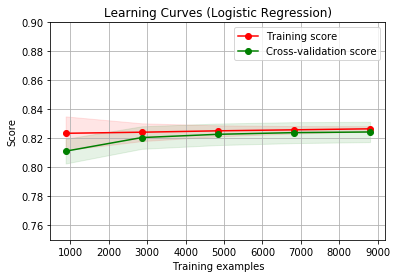

In [14]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    return plt

X, y = data_clean.iloc[:,:-1].values, data_clean.iloc[:,-1].values
title = "Learning Curves (Logistic Regression)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = linear_model.LogisticRegression()
plot_learning_curve(estimator, title, X, y, ylim=(0.75, 0.90), cv=cv, n_jobs=4)
plt.show()

## ROC Curve plot function

<p>
<span style="color:blue">
This is a callable ROC curve plot function. We have used this function to plot ROC Curve for all the models. We have used Seaborn package.
</span>
</p>

In [15]:
import seaborn as sns
sns.set('talk', 'whitegrid', 'dark', font_scale=1, font='Ricty',rc={"lines.linewidth": 2, 'grid.linestyle': '--'})
def plotAUC(truth, pred, lab):
    fpr, tpr, _ = metrics.roc_curve(truth,pred)
    roc_auc = metrics.auc(fpr, tpr)
    lw = 2
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.plot(fpr, tpr, color= c,lw=lw, label= lab +'(AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve') #Receiver Operating Characteristic 
    plt.legend(loc="lower right")

## Confusion Matrix Viz function

<p>
<span style="color:blue">
This is a callable Confusion Matrix Visualization function. We have used this function to visualize True positives, True Negatives, False Positives and False Negatives for all the models.
</span>
</p>

In [16]:
import itertools
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(model, normalize=False): # This function prints and plots the confusion matrix.
    cm = confusion_matrix(y_test, model, labels=[0, 1])
    classes=["Will Pay", "Will Default"]
    cmap = plt.cm.Blues
    title = "Confusion Matrix"
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=3)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [17]:
X_train, X_test, y_train, y_test = train_test_split(data_clean.iloc[:,:-1], data_clean.iloc[:,-1], test_size=0.2, random_state=42)
bs_train, bs_test = train_test_split(data_clean, test_size = 0.2, random_state=42) #just for bootstrapping

In [18]:
X_train.head()

,funded_amnt,annual_inc,home_ownership,grade,last_pymnt_amnt,mort_acc,pub_rec,int_rate,open_acc,num_actv_rev_tl,mo_sin_rcnt_rev_tl_op,mo_sin_old_rev_tl_op,bc_util,bc_open_to_buy,avg_cur_bal,acc_open_past_24mths
10735,-0.187049,-0.833955,-2.169797,0.608417,0.918916,-0.381210,-0.323493,-0.660046,-0.066721,0.095919,-0.672469,-0.088144,-1.447178,0.259472,-0.778103,0.644802
5937,-0.529397,0.160664,0.893285,-0.159362,-0.696214,1.474658,-0.323493,0.527815,-0.468455,-0.929244,0.300427,0.299524,1.127731,-0.612128,1.631570,1.367561
7642,-0.577871,-0.527667,-2.169797,0.608417,-0.334613,-0.381210,-0.323493,-0.505009,0.736746,0.779361,-0.802189,-0.407400,-0.667019,0.280576,-0.630618,0.644802
3328,2.051848,0.101877,0.893285,-1.694921,-0.595380,-0.381210,-0.323493,1.845634,0.134145,0.779361,-0.023872,-1.444981,0.266866,-0.165814,0.278478,-0.077956
8681,0.561270,-0.453252,-0.638256,-0.927142,-0.656025,-0.845176,-0.323493,1.132005,0.335012,0.437640,-0.088732,-0.863480,0.674239,-0.374800,-0.467352,-0.439335


###  Feature Selection using RFE (Recursive Feature Elimination) 

In [19]:
from sklearn.feature_selection import RFE
# create the RFE model and select 3 attributes
clf_LR = linear_model.LogisticRegression(C=1e30)
clf_LR.fit(X_train,y_train)
rfe = RFE(clf_LR, 10)
rfe = rfe.fit(data_clean.iloc[:,:-1].values, data_clean.iloc[:,-1].values)
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)
# ['funded_amnt','emp_length','annual_inc','home_ownership','grade',"last_pymnt_amnt", "mort_acc", "pub_rec", 
# "int_rate", "open_acc","num_actv_rev_tl","mo_sin_rcnt_rev_tl_op","mo_sin_old_rev_tl_op","bc_util","bc_open_to_buy",
#"avg_cur_bal","acc_open_past_24mths",'loan_status']

[ True  True False  True  True False  True  True False False False False
  True  True  True  True]
[1 1 5 1 1 7 1 1 3 2 4 6 1 1 1 1]


In [20]:
#PCA (Principal Component Analysis)
from sklearn.decomposition import PCA 
pca = PCA(n_components=10, whiten=True)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_
print('Expected Variance is '+ str(explained_variance))

Expected Variance is [0.173779   0.16138249 0.13630567 0.07664199 0.07532025 0.06859439
 0.05213437 0.04885806 0.04126088 0.03747799]


In [21]:
features = ['funded_amnt','annual_inc','grade',"last_pymnt_amnt", "int_rate",
            "mo_sin_rcnt_rev_tl_op","mo_sin_old_rev_tl_op","bc_util","bc_open_to_buy","acc_open_past_24mths","loan_status"]
X_train, X_test = X_train[features[:-1]], X_test[features[:-1]]
data_clean = data_clean[features]
print(X_train.shape)
print(data_clean.shape)

(8800, 10)
(11000, 11)


C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

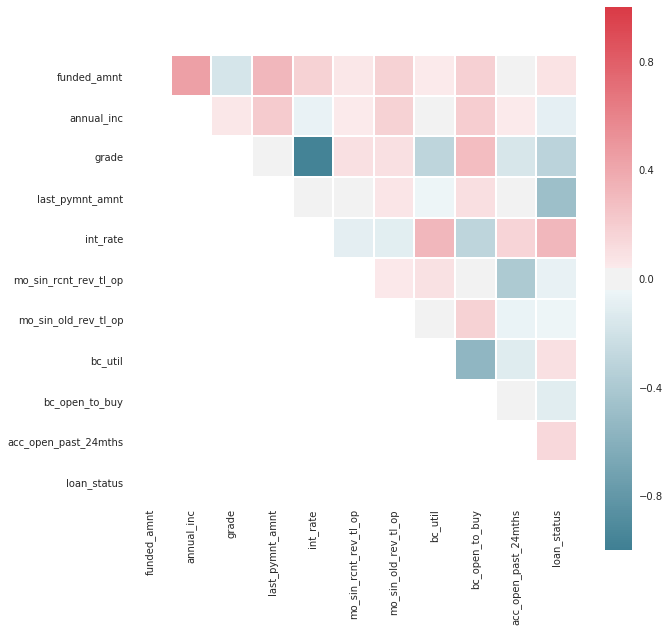

In [22]:
dataViz = data_clean
sns.set_context(context='notebook')
fig, ax = plt.subplots(figsize=(10,10)) 
corr = dataViz.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.tril_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, cmap=cmap,linewidths=1, vmin=-1, vmax=1, square=True, cbar=True, center=0, ax=ax, mask=mask)

# Models


## Random Forest with randomized Search

<p>
<span style="color:blue">
Random forest when implemented with randomized search we got the best accuracies and minimum false negatives(predicting borowwer will not default eventhough he will. This might impact on the credibility of the company). We used the randomized search to find the best hyper paramters for the model.
</span>
</p>

In [23]:
from sklearn.grid_search import RandomizedSearchCV
rf = RandomForestClassifier(criterion='gini', random_state=0)
maxFeatures = range(1,data_clean.shape[1]-1)
param_dist = dict(max_features=maxFeatures)
rand = RandomizedSearchCV(rf, param_dist, cv=10, scoring='accuracy', n_iter=len(maxFeatures), random_state=10)
X=data_clean.iloc[:,:-1].values
y=data_clean.iloc[:,-1].values
rand.fit(X,y)
mean_scores = [result.mean_validation_score for result in rand.grid_scores_]
#print('Best Accuracy = '+str(rand.best_score_))
print(rand.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)


In [24]:
randomForest = RandomForestClassifier(bootstrap=True,criterion = "gini",max_features=rand.best_estimator_.max_features,random_state=0 )
randomForest.fit(X_train,y_train)
rfPredict = randomForest.predict(X_test)
rfPredictproba = randomForest.predict_proba(X_test)[:,1] #for ROC curve
rfAccuracy = accuracy_score(y_test,rfPredict)
roc_score = metrics.roc_auc_score(y_test,rfPredict)
print(rfAccuracy)

0.8104545454545454


## Feature Importance

Text(0,0.5,'Normalized Gini Importance')

C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

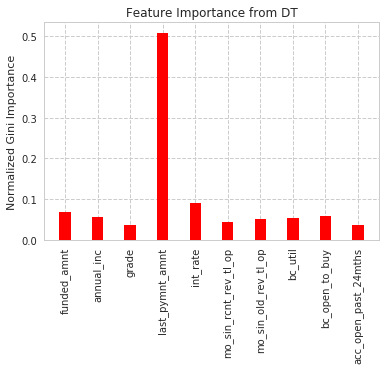

In [25]:
fig, ax = plt.subplots()
width=0.35
ax.bar(np.arange(len(features)-1), randomForest.feature_importances_, width, color='r')
ax.set_xticks(np.arange(len(randomForest.feature_importances_)))
ax.set_xticklabels(X_train.columns.values,rotation=90)
plt.title('Feature Importance from DT')
ax.set_ylabel('Normalized Gini Importance')

C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

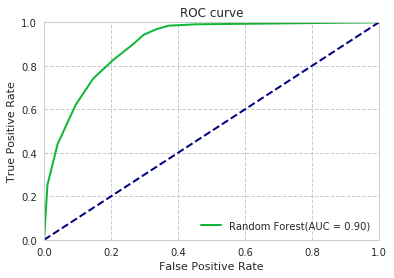

C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

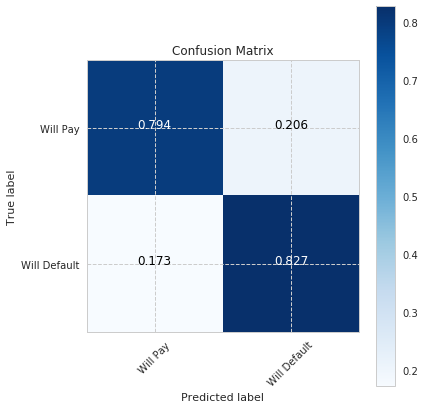

In [26]:
plotAUC(y_test,rfPredictproba, 'Random Forest')
plt.show()
plt.figure(figsize=(6,6))
plot_confusion_matrix(rfPredict, normalize=True)
plt.show()

## Logistic Regression with Grid Search


<p>
<span style="color:blue">
Logistic Regression when implemented with grid search we got the best accuracies and minimum false negatives. We used the randomized search to find the best hyper paramters for the model.
</span>
</p>

In [27]:
from sklearn.model_selection import GridSearchCV
def cross_validation_best_parameters(model, param_grid):
    grid = GridSearchCV(model, param_grid,cv=10, scoring='accuracy')
    X=data_clean.iloc[:,:-1].values
    y=data_clean.iloc[:,-1].values
    grid.fit(X,y)
    mean_scores = [result.mean_validation_score for result in grid.grid_scores_]
    return mean_scores,grid.best_score_,grid.best_estimator_
logreg = linear_model.LogisticRegression(random_state=0)
c=[0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_grid = dict(C=c)
mean_scores,Best_Accuracy, Best_classifier = cross_validation_best_parameters(logreg,param_grid)
print("Best accuracy is "+ str(Best_Accuracy))
print(Best_classifier)

Best accuracy is 0.8277272727272728
LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Logistic regression accuracy is  0.8227272727272728


C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

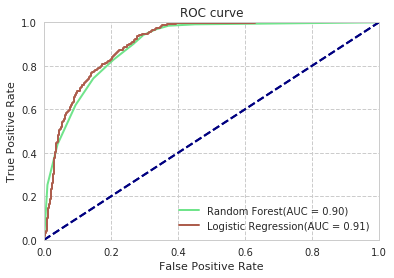

C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

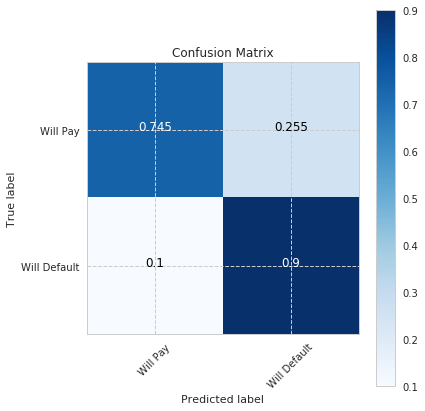

In [28]:
clf_LR = linear_model.LogisticRegression(C=Best_classifier.C)
clf_LR.fit(X_train,y_train)
LR_Predict = clf_LR.predict_proba(X_test)[:,1]
LR_Predict_bin = clf_LR.predict(X_test)
LR_Accuracy = accuracy_score(y_test,LR_Predict.round())
print("Logistic regression accuracy is ",LR_Accuracy)
plotAUC(y_test,rfPredictproba, 'Random Forest')
plotAUC(y_test,LR_Predict,'Logistic Regression')
plt.show()
plt.figure(figsize=(6,6))
plot_confusion_matrix(LR_Predict_bin, normalize=True)
plt.show()

## Support Vector Machines(SVM) with Grid Search CV

<p>
<span style="color:blue">
SVM (Support Vector Machines) when implemented with grid search, we got the best accuracies and minimum false negatives. We used the Grid search to find the best hyper paramters for the model.Later we used this value to find the predictions and plot the ROC curve.
</span>
</p>

In [30]:
from sklearn.grid_search import GridSearchCV    ## takes too much time to run this cell.
clf_svm = svm.SVC()
powers = range(0,5)
cs = [10**i for i in powers]
param_grid = dict(C=cs)
grid = GridSearchCV(clf_svm, param_grid, cv=10, scoring='accuracy')
grid.fit(data_clean.iloc[:,:-1].values, data_clean.iloc[:,-1].values)
grid_mean_scores = [result.mean_validation_score for result in grid.grid_scores_]# create a list of the mean scores only
print(grid.best_params_)
print("---------------")
print(grid.best_estimator_)

{'C': 10}
---------------
SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


SVM accuracy is  0.82


C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

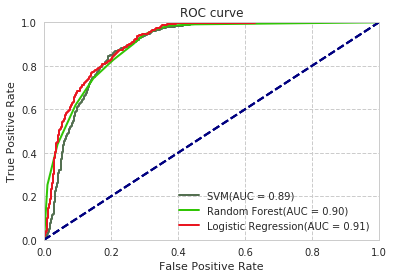

C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

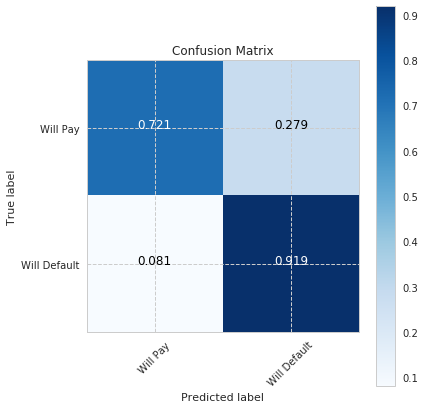

In [31]:
clf_svm = svm.SVC(kernel = "rbf", C=grid.best_estimator_.C)
clf_svm.fit(X_train.iloc[:,:],y_train)
predictions_svm = clf_svm.predict(X_test.iloc[:,:])
predictproba_svm = clf_svm.decision_function(X_test.iloc[:,:])
SVM_Accuracy = accuracy_score(y_test,predictions_svm)
print("SVM accuracy is ",SVM_Accuracy)
plotAUC(y_test,predictproba_svm, 'SVM')
plotAUC(y_test,rfPredictproba, 'Random Forest')
plotAUC(y_test,LR_Predict,'Logistic Regression')
plt.show()
plt.figure(figsize=(6,6))
plot_confusion_matrix(predictions_svm, normalize=True)
plt.show()

## K Nearest Neighbors(KNN) with Grid Search CV

<p>
<span style="color:blue">
KNN (K Nearest Neighbors) when implemented with grid search, we got the best accuracies and minimum false negatives. 
We used the Grid search to find the best hyper paramters for the model.Later we used this value to find the predictions and plot the ROC curve.
</span>
</p>

In [32]:
#KNN_Acc = knnfunc(2,10) - 74.8 max, 75.7 for 15, 25 - 76.2, 30 - 76.1
from sklearn.grid_search import GridSearchCV    ## takes too much time to run this cell.
clf_knn = KNeighborsClassifier()
k_range = list(range(35, 50))
param_grid = dict(n_neighbors=k_range)
grid = GridSearchCV(clf_knn, param_grid, cv=10, scoring='accuracy')
grid.fit(data_clean.iloc[:,:-1].values, data_clean.iloc[:,-1].values)
grid_mean_scores = [result.mean_validation_score for result in grid.grid_scores_]# create a list of the mean scores only
print(grid.best_params_)
print("---------------")
print(grid.best_estimator_)

{'n_neighbors': 48}
---------------
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=48, p=2,
           weights='uniform')


 48
KNN accuracy is  0.7754545454545455


C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

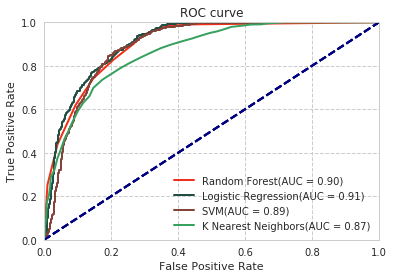

C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

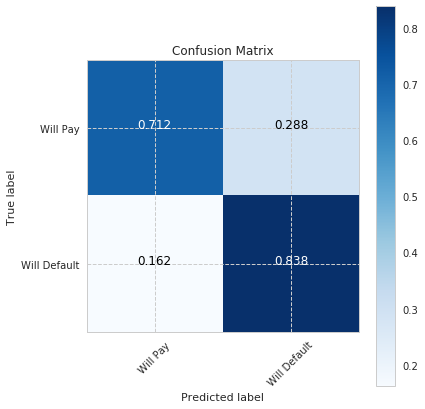

In [33]:
print("",grid.best_params_['n_neighbors'])
clf_knn_final = KNeighborsClassifier(n_neighbors=grid.best_params_['n_neighbors'])   #taking the the best from the above cell and using it to find predictions
clf_knn_final.fit(X_train,y_train)
knn_pred = clf_knn_final.predict(X_test)
knn_predictproba = clf_knn_final.predict_proba(X_test)[:,1]
KNN_Acc = accuracy_score(y_test,knn_pred)
print("KNN accuracy is ",KNN_Acc)
plotAUC(y_test,rfPredictproba, 'Random Forest')
plotAUC(y_test,LR_Predict,'Logistic Regression')
plotAUC(y_test,predictproba_svm, 'SVM')
plotAUC(y_test,knn_predictproba,'K Nearest Neighbors')
plt.show()
plt.figure(figsize=(6,6))
plot_confusion_matrix(knn_pred, normalize=True)
plt.show()

## Bagging for Classification

<p>
<span style="color:blue">
Our accuracy increased by 2 percent after using grid search and randomized search cross validation techniques. we have tried following ensemble algorithms to check if they can give better results. <br>
Bagging : <br>
> Create many random sub-samples of our dataset with replacement. <br>
> Train a CART(Classfication and Regression Trees) model on each sample.   <br>
> Given a new dataset, calculate the average prediction from each model <br>
</span>
</p>  

In [34]:
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
seed = 7
kfold = model_selection.KFold(n_splits=10, random_state=seed)
num_trees = 100
model = BaggingClassifier(base_estimator=randomForest, n_estimators=num_trees, random_state=seed)
results = model_selection.cross_val_score(model, data_clean.iloc[:,:-1].values, data_clean.iloc[:,-1].values, cv=kfold)
print(results.mean())

0.8371818181818181


In [35]:
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
seed = 7
kfold = model_selection.KFold(n_splits=10, random_state=seed)
#num_trees = 100
model = BaggingClassifier(base_estimator=clf_LR, random_state=seed)
results = model_selection.cross_val_score(model, data_clean.iloc[:,:-1].values, data_clean.iloc[:,-1].values, cv=kfold)
print(results.mean())

0.8273636363636363


## Ada Boost classifier

<p>
<span style="color:blue">
Ada Boost is one of the most commonly used ensemble algorithms. <br>
It works by weighting instances in the dataset by how easy or difficult they are to classify, allowing the algorithm to pay or or less attention to them in the construction of subsequent models. <br>
</span>
</p>  

In [36]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier
Ada_clf = AdaBoostClassifier(n_estimators=50)
scores = cross_val_score(Ada_clf, data_clean.iloc[:,:-1].values, data_clean.iloc[:,-1].values)
scores.mean()

0.8316342041370465

## Multi-Layer Perceptron Classifier

<p>
<span style="color:blue">
A multilayer perceptron (MLP) is a feedforward artificial neural network. An MLP consists of at least three layers of nodes. MLP utilizes a supervised learning technique called backpropagation for training.Its multiple layers and non-linear activation distinguish MLP from a linear perceptron. It can distinguish data that is not linearly separable. We got our highest accuracy for MLP classifier(little higher than Logistic Regression with Grid Search CV).
</span>
</p>

0.8281818181818181


C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

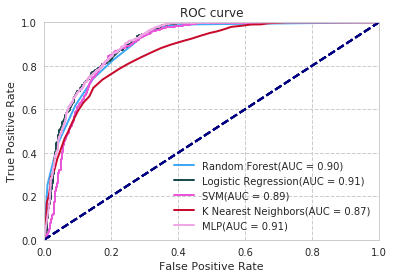

C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

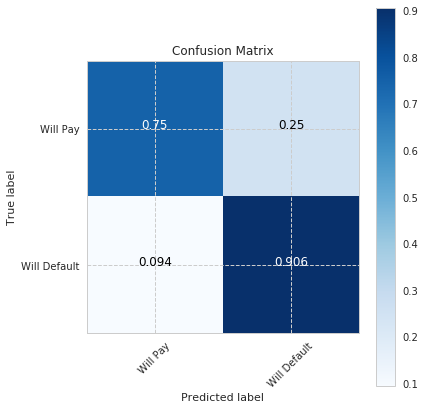

In [37]:
from sklearn.neural_network import MLPClassifier
clf_NN = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
clf_NN.fit(X_train,y_train)     
predict_NN = clf_NN.predict(X_test)
predictproba_NN = clf_NN.predict_proba(X_test)[:,1]
NNAccuracy = accuracy_score(y_test,predict_NN)
print(NNAccuracy)
plotAUC(y_test,rfPredictproba, 'Random Forest')
plotAUC(y_test,LR_Predict,'Logistic Regression')
plotAUC(y_test,predictproba_svm, 'SVM')
plotAUC(y_test,knn_predictproba,'K Nearest Neighbors')
plotAUC(y_test,predictproba_NN,'MLP')
plt.show()
plt.figure(figsize=(6,6))
plot_confusion_matrix(predict_NN, normalize=True)
plt.show()

## Precision,recall,F1score for all models

In [38]:
from sklearn.metrics import classification_report
print("RF",classification_report(y_test, rfPredict, target_names=None))
print("SVM",classification_report(y_test, predictions_svm, target_names=None))
print("LR",classification_report(y_test, LR_Predict_bin, target_names=None))
print("KNN",classification_report(y_test, knn_pred, target_names=None))
print("MLP",classification_report(y_test, predict_NN, target_names=None))

RF              precision    recall  f1-score   support

          0       0.82      0.79      0.81      1095
          1       0.80      0.83      0.81      1105

avg / total       0.81      0.81      0.81      2200

SVM              precision    recall  f1-score   support

          0       0.90      0.72      0.80      1095
          1       0.77      0.92      0.84      1105

avg / total       0.83      0.82      0.82      2200

LR              precision    recall  f1-score   support

          0       0.88      0.75      0.81      1095
          1       0.78      0.90      0.84      1105

avg / total       0.83      0.82      0.82      2200

KNN              precision    recall  f1-score   support

          0       0.81      0.71      0.76      1095
          1       0.75      0.84      0.79      1105

avg / total       0.78      0.78      0.77      2200

MLP              precision    recall  f1-score   support

          0       0.89      0.75      0.81      1095
          1    

## Behaviour of models with different sample sizes of dataset

<p>
<span style="color:blue">
Here we have plotted ROC_AUC_Score for different sample sizes similar to what we have done in one of the assignments.
</span>
</p>

In [39]:
def modBootstrapper(train, test, nruns, sampsize, model, c):
    target = 'loan_status'
    aucs_boot = []
    for i in range(nruns):
        train_samp = train.iloc[np.random.randint(0, len(train), size = sampsize)] #selecting random indexes for KFold
        if (model == "LR"):
            lr_i = linear_model.LogisticRegression(C = 1e30)
            lr_i.fit(train_samp.drop(target,1), train_samp[target]) #Logistic regression
            p = lr_i.predict_proba(test.drop(target,1))[:,1]
        elif (model == "SVM"):
            svm_i = svm.SVC(kernel='rbf', C = c) 
            svm_i.fit(train_samp.drop(target,1), train_samp[target])#SVM fitting and predicting if lr==0
            p = svm_i.decision_function(test.drop(target,1))
        elif (model == "RF"):
            RF_i = RandomForestClassifier(bootstrap=True,criterion = "gini")
            RF_i.fit(train_samp.drop(target,1), train_samp[target])
            p = RF_i.predict_proba(X_test)[:,1]
        elif (model == "KNN"):
            knn_i = KNeighborsClassifier(n_neighbors= 30) #taking the the best from the above cell and using it to find predictions
            knn_i.fit(train_samp.drop(target,1), train_samp[target])
            p = knn_i.predict_proba(X_test)[:,1]
            
        aucs_boot.append(metrics.roc_auc_score(test[target], p)) #calculating auc scores for each bag in bootstrapping
    
    return [np.mean(aucs_boot), np.sqrt(np.var(aucs_boot))] #mean, standard error = square root of variance

In [40]:
bs_train, bs_test = train_test_split(data_clean, test_size = 0.2, random_state=42) #just for bootstrapping
SampleSizes = [250,1000,1500,2000,2750,3750,4500,5200,6500,7000,8000,8500,9000,10000,11000] #various samples of Dataset
LR_means = []
Lr_stderr = []
svm_means = []
svm_stderr = []
RF_means = []
RF_stderr = []
KNN_means = []
KNN_stderr = []
for n in SampleSizes:
    mean, err = modBootstrapper(bs_train, bs_test, 20, n, "LR", 0.1)# collecting means and stderrs for LR model
    LR_means.append(mean)
    Lr_stderr.append(err)
    mean2, err2 = modBootstrapper(bs_train, bs_test, 20, n,"SVM", 0.1)# collecting means and stderrs for SVM model
    svm_means.append(mean2)
    svm_stderr.append(err2)
    mean3, err3 = modBootstrapper(bs_train, bs_test, 20, n,"RF", 0.1)# collecting means and stderrs for SVM model
    RF_means.append(mean3)
    RF_stderr.append(err3)
    mean4, err4 = modBootstrapper(bs_train, bs_test, 20, n,"KNN", 0.1)# collecting means and stderrs for SVM model
    KNN_means.append(mean4)
    KNN_stderr.append(err4)
    print(n)  

250
1000
1500
2000
2750
3750
4500
5200
6500
7000
8000
8500
9000
10000
11000


Text(0,0.5,'roc_auc_score')

C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\c

C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\Madeeha\AppData\Local\conda\conda\envs\faisal\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


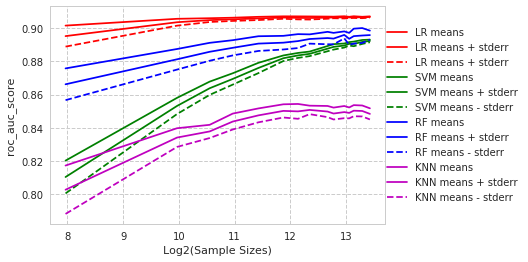

In [41]:
plt.plot(np.log2(SampleSizes), LR_means, 'r', label = 'LR means')
plt.plot(np.log2(SampleSizes), LR_means + np.array(Lr_stderr), 'r+-', label = 'LR means + stderr')
plt.plot(np.log2(SampleSizes), LR_means - np.array(Lr_stderr), 'r--',  label = 'LR means + stderr')

plt.plot(np.log2(SampleSizes), svm_means, 'g', label = 'SVM means')
plt.plot(np.log2(SampleSizes), svm_means + np.array(svm_stderr), 'g+-', label = 'SVM means + stderr')
plt.plot(np.log2(SampleSizes), svm_means - np.array(svm_stderr), 'g--', label = 'SVM means - stderr')

plt.plot(np.log2(SampleSizes), RF_means, 'b', label = 'RF means')
plt.plot(np.log2(SampleSizes), RF_means + np.array(RF_stderr), 'b+-', label = 'RF means + stderr')
plt.plot(np.log2(SampleSizes), RF_means - np.array(RF_stderr), 'b--', label = 'RF means - stderr')

plt.plot(np.log2(SampleSizes), KNN_means, 'm', label = 'KNN means')
plt.plot(np.log2(SampleSizes), KNN_means + np.array(KNN_stderr), 'm+-', label = 'KNN means + stderr')
plt.plot(np.log2(SampleSizes), KNN_means - np.array(KNN_stderr), 'm--', label = 'KNN means - stderr')

plt.legend(bbox_to_anchor=(1.20, 0.5),loc = 10)
plt.xlabel('Log2(Sample Sizes)')
plt.ylabel('roc_auc_score')